<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
#Dropping columns with greater than 50% null values along with ID column

In [6]:
house.drop(['Id','Alley','FireplaceQu','GarageFinish','PoolQC','Fence','MiscFeature'] , axis=1, inplace=True)

##### Feature engineering

In [7]:
#New feature added: Total square feel calculated from three given columns

In [8]:
house['Total_SF'] = house['TotalBsmtSF'] + house['1stFlrSF']+ house['2ndFlrSF']

In [9]:
#dropped three columns from above

In [10]:
house.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)

##### Data cleaning
--> cleaning null values
--> replacing null vlaues with median values when needed

In [11]:
house.LotFrontage.value_counts(dropna=False)

NaN       259
 60.0     143
 70.0      70
 80.0      69
 50.0      57
 75.0      53
 65.0      44
 85.0      40
 78.0      25
 21.0      23
 90.0      23
 68.0      19
 24.0      19
 64.0      19
 73.0      18
 72.0      17
 79.0      17
 63.0      17
 55.0      17
 100.0     16
 51.0      15
 66.0      15
 74.0      15
 52.0      14
 59.0      13
 71.0      12
 67.0      12
 57.0      12
 82.0      12
 43.0      12
         ... 
 129.0      2
 313.0      2
 118.0      2
 122.0      2
 121.0      2
 101.0      2
 109.0      2
 115.0      2
 116.0      2
 114.0      2
 153.0      1
 149.0      1
 150.0      1
 111.0      1
 182.0      1
 46.0       1
 112.0      1
 141.0      1
 33.0       1
 152.0      1
 160.0      1
 168.0      1
 128.0      1
 144.0      1
 39.0       1
 106.0      1
 38.0       1
 138.0      1
 140.0      1
 137.0      1
Name: LotFrontage, Length: 111, dtype: int64

In [12]:
house.drop(['LotFrontage'], axis=1, inplace=True)

In [13]:
house.select_dtypes(include = [object]).columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageQual', 'GarageCond', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [14]:
house.isnull().sum()

MSSubClass        0
MSZoning          0
LotArea           0
Street            0
LotShape          0
LandContour       0
Utilities         0
LotConfig         0
LandSlope         0
Neighborhood      0
Condition1        0
Condition2        0
BldgType          0
HouseStyle        0
OverallQual       0
OverallCond       0
YearBuilt         0
YearRemodAdd      0
RoofStyle         0
RoofMatl          0
Exterior1st       0
Exterior2nd       0
MasVnrType        8
MasVnrArea        8
ExterQual         0
ExterCond         0
Foundation        0
BsmtQual         37
BsmtCond         37
BsmtExposure     38
                 ..
BsmtFullBath      0
BsmtHalfBath      0
FullBath          0
HalfBath          0
BedroomAbvGr      0
KitchenAbvGr      0
KitchenQual       0
TotRmsAbvGrd      0
Functional        0
Fireplaces        0
GarageType       81
GarageYrBlt      81
GarageCars        0
GarageArea        0
GarageQual       81
GarageCond       81
PavedDrive        0
WoodDeckSF        0
OpenPorchSF       0


In [15]:
house.GarageQual.replace(np.nan, 'TA', inplace=True)

In [16]:
house.GarageCond.replace(np.nan, 'TA', inplace=True)

In [17]:
house['MasVnrType'].replace(np.nan, 'None', inplace=True)

In [18]:
house.BsmtQual.replace(np.nan, 'TA', inplace=True)

In [19]:
house.BsmtExposure.replace(np.nan, 'No', inplace=True)

In [20]:
house.BsmtFinType1.replace(np.nan, 'Unf', inplace=True)

In [21]:
house.BsmtFinType2.replace(np.nan, 'Unf', inplace=True)

In [22]:
house.Electrical.replace(np.nan, 'SBrkr', inplace=True)

In [23]:
house.GarageType.replace(np.nan, 'No Garage', inplace=True)

In [24]:
house.GarageYrBlt.value_counts(dropna=False)

NaN        81
 2005.0    65
 2006.0    59
 2004.0    53
 2003.0    50
 2007.0    49
 1977.0    35
 1998.0    31
 1999.0    30
 1976.0    29
 2008.0    29
 2000.0    27
 2002.0    26
 1968.0    26
 1950.0    24
 1993.0    22
 1962.0    21
 2009.0    21
 1966.0    21
 1965.0    21
 1958.0    21
 1970.0    20
 1996.0    20
 1957.0    20
 2001.0    20
 1997.0    19
 1978.0    19
 1960.0    19
 1954.0    19
 1974.0    18
           ..
 1916.0     5
 1922.0     5
 1936.0     5
 1945.0     4
 1946.0     4
 1982.0     4
 1931.0     4
 1928.0     4
 1935.0     4
 1932.0     3
 1952.0     3
 1921.0     3
 1938.0     3
 2010.0     3
 1910.0     3
 1924.0     3
 1923.0     3
 1947.0     2
 1918.0     2
 1929.0     2
 1914.0     2
 1915.0     2
 1934.0     2
 1937.0     2
 1942.0     2
 1906.0     1
 1927.0     1
 1900.0     1
 1908.0     1
 1933.0     1
Name: GarageYrBlt, Length: 98, dtype: int64

In [25]:
house.GarageYrBlt.replace(np.nan, 'No Garage', inplace=True)

In [26]:
house.drop(house.loc[house['MSZoning'] =='C (all)'].index, inplace=True)

In [27]:
house.BsmtCond.value_counts(dropna=False)

TA     1303
Gd       65
Fa       43
NaN      37
Po        2
Name: BsmtCond, dtype: int64

In [28]:
house.BsmtCond.replace(np.nan, 'No Basement', inplace=True)

### EDA

In [29]:
#Trying to get an idea of what features greatly influence the sale price
##few graphs and correlation heat map to see correlation of numerical feat with sale price

C:\Users\anita\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


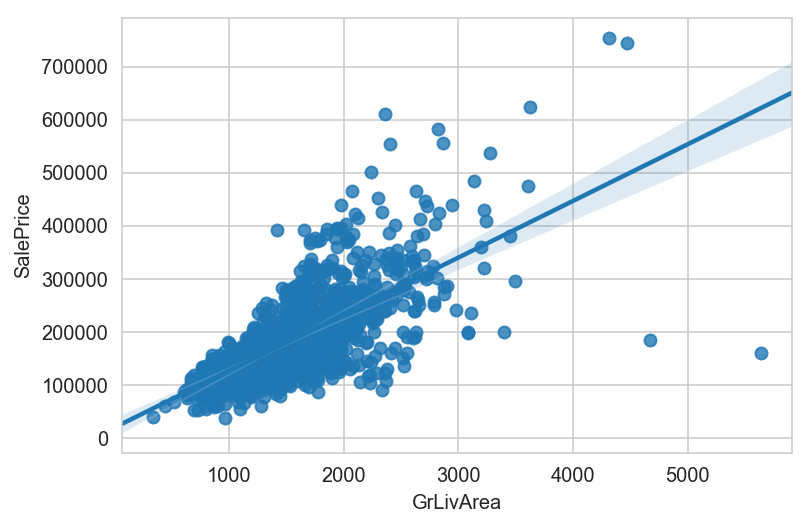

In [30]:
sns.regplot(house.GrLivArea, house.SalePrice)

In [31]:
#OUTLIERS:#We have 2 houses with very big liv area but low sale price, so i decided to drop them as it will try
#to pull the regression line down and affect the good fit

In [32]:
house.drop(house.loc[house['GrLivArea'] > 4500].index, inplace=True)

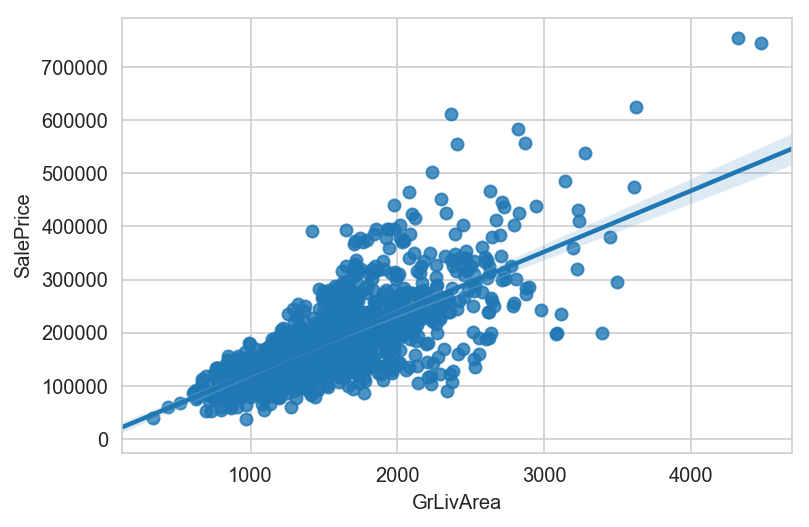

In [33]:
sns.regplot(house.GrLivArea, house.SalePrice)

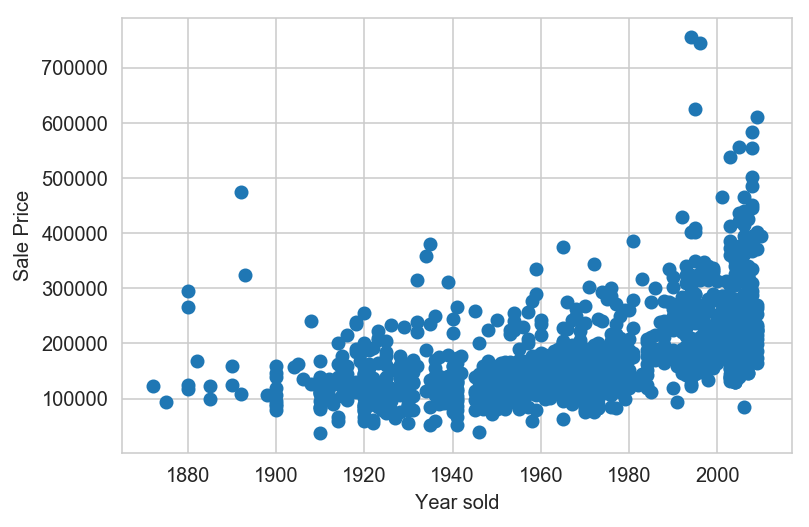

In [34]:
plt.scatter('YearBuilt','SalePrice',data=house)
plt.xlabel('Year sold');
plt.ylabel('Sale Price');
#There are more houses sold as the year increases
##

(1850, 2050)

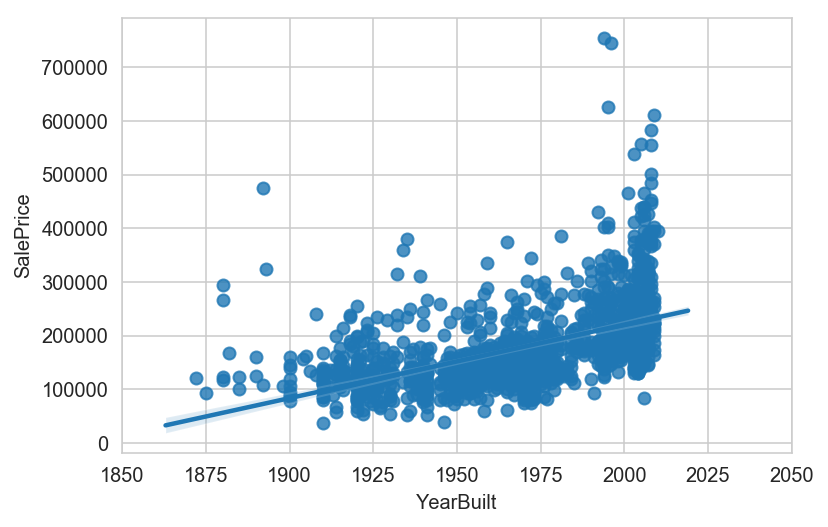

In [35]:
sns.regplot(house.YearBuilt, house.SalePrice)
plt.xlim(1850,2050)

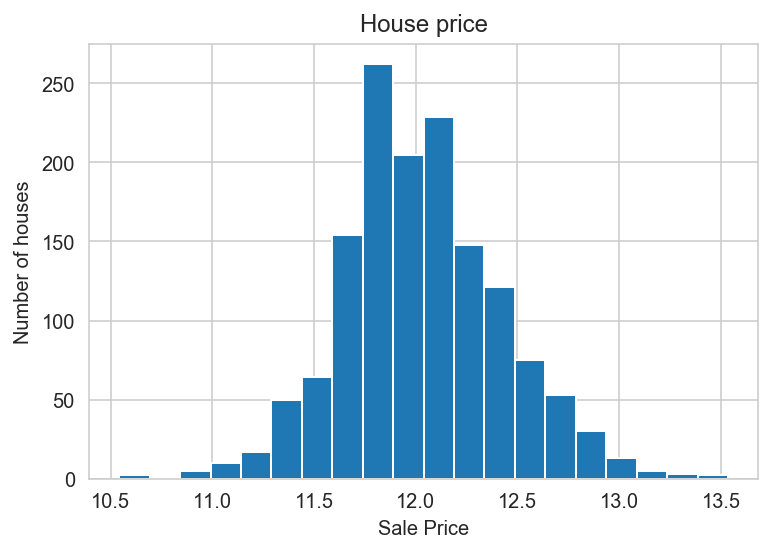

In [36]:
plt.hist(np.log(house['SalePrice']), bins=20);
plt.xlabel('Sale Price');
plt.ylabel('Number of houses');
plt.title('House price');
#the sale price distribution is slightly skewed so we will need to convert it into log so it follows normality
#as per on of the linear regression assumptions

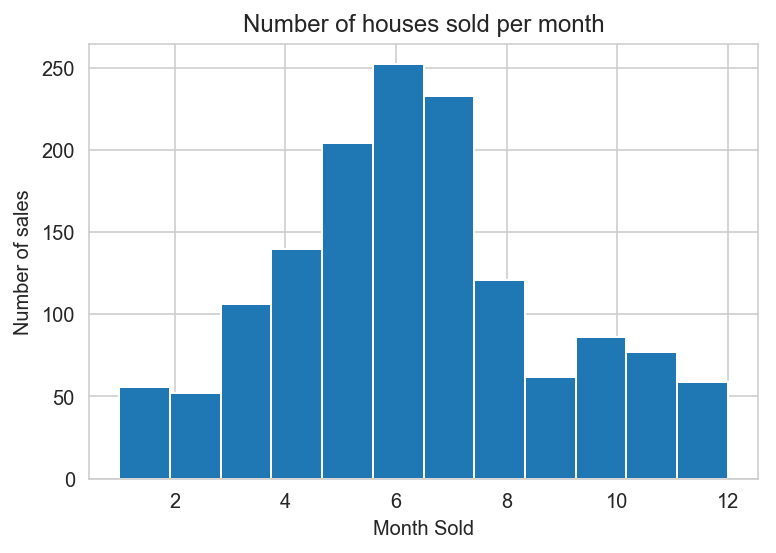

In [37]:
plt.hist(house['MoSold'], bins=12);
plt.xlabel('Month Sold');
plt.ylabel('Number of sales');
plt.title('Number of houses sold per month');
# there are more houses sold in June month, summer time
#less houses sold in the colder months

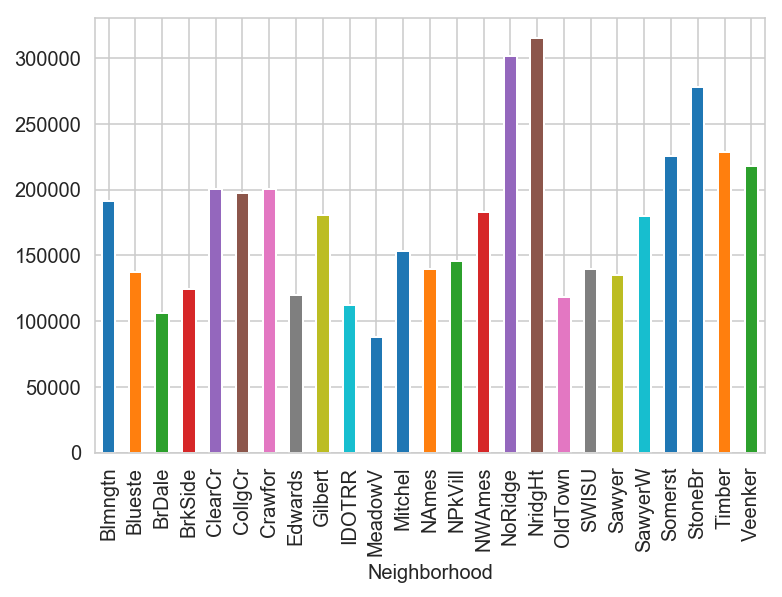

In [38]:
median_saleprice = house.groupby('Neighborhood')['SalePrice'].median();
median_saleprice.plot.bar();
#house prices depending on the neighborhood

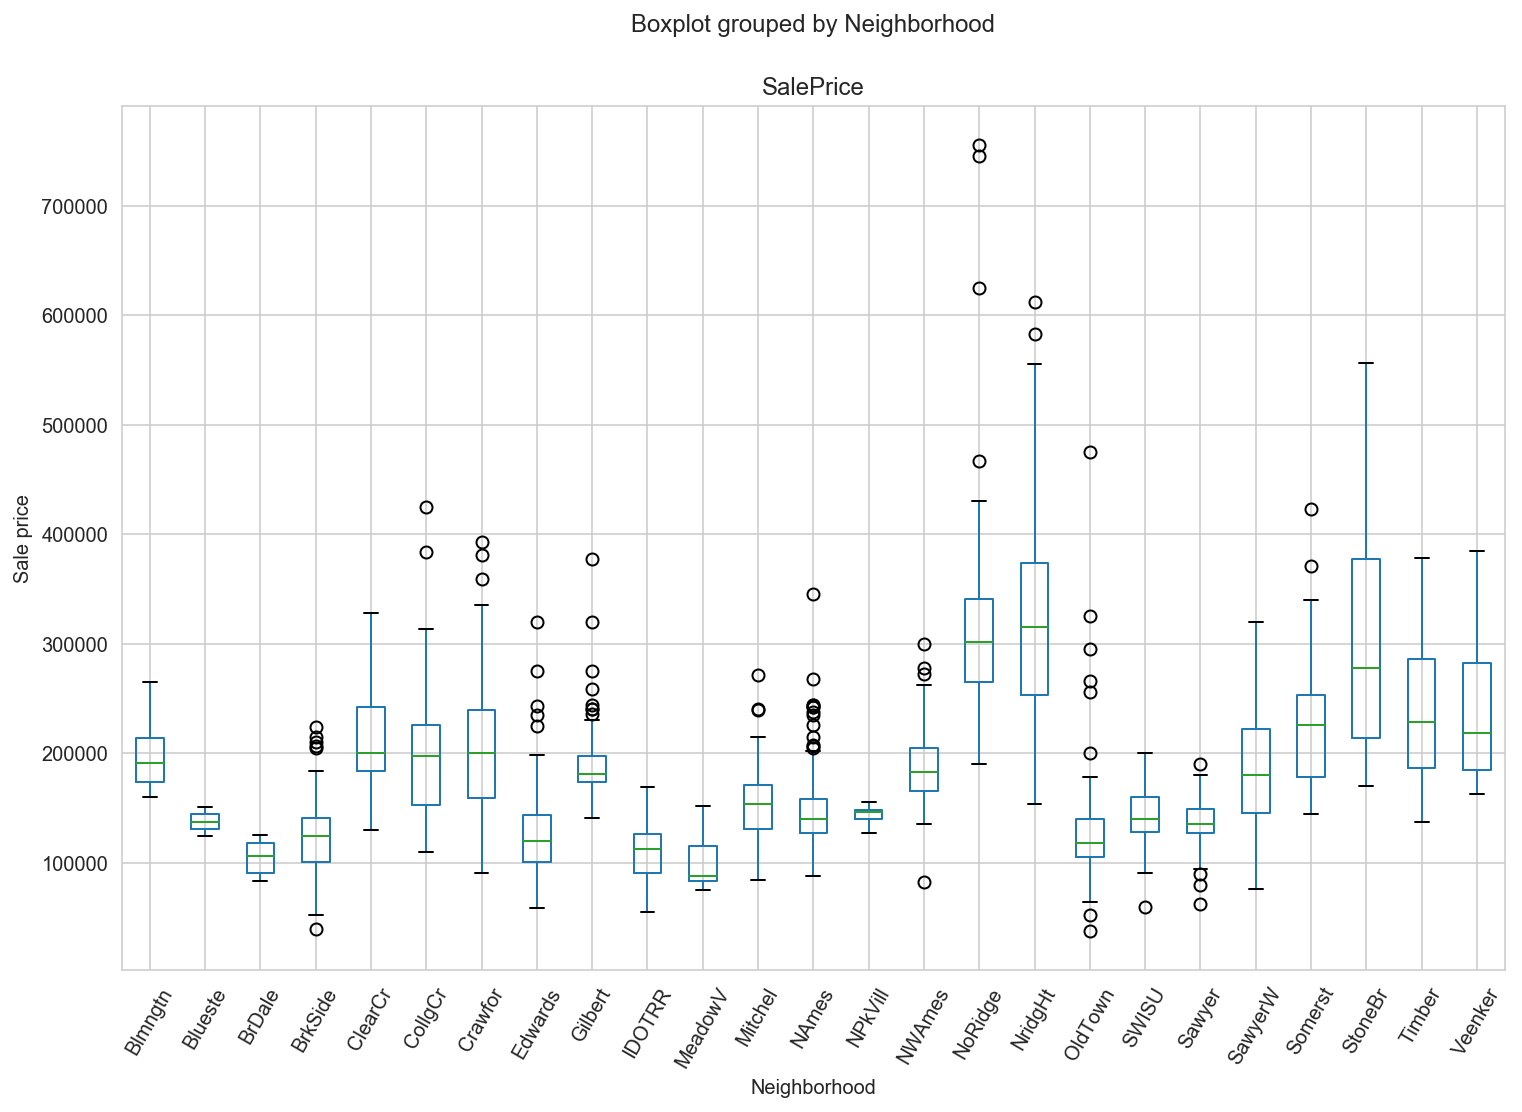

In [39]:
house.boxplot(column = 'SalePrice',by='Neighborhood', rot=60, figsize=(12,8));
plt.ylabel('Sale price');

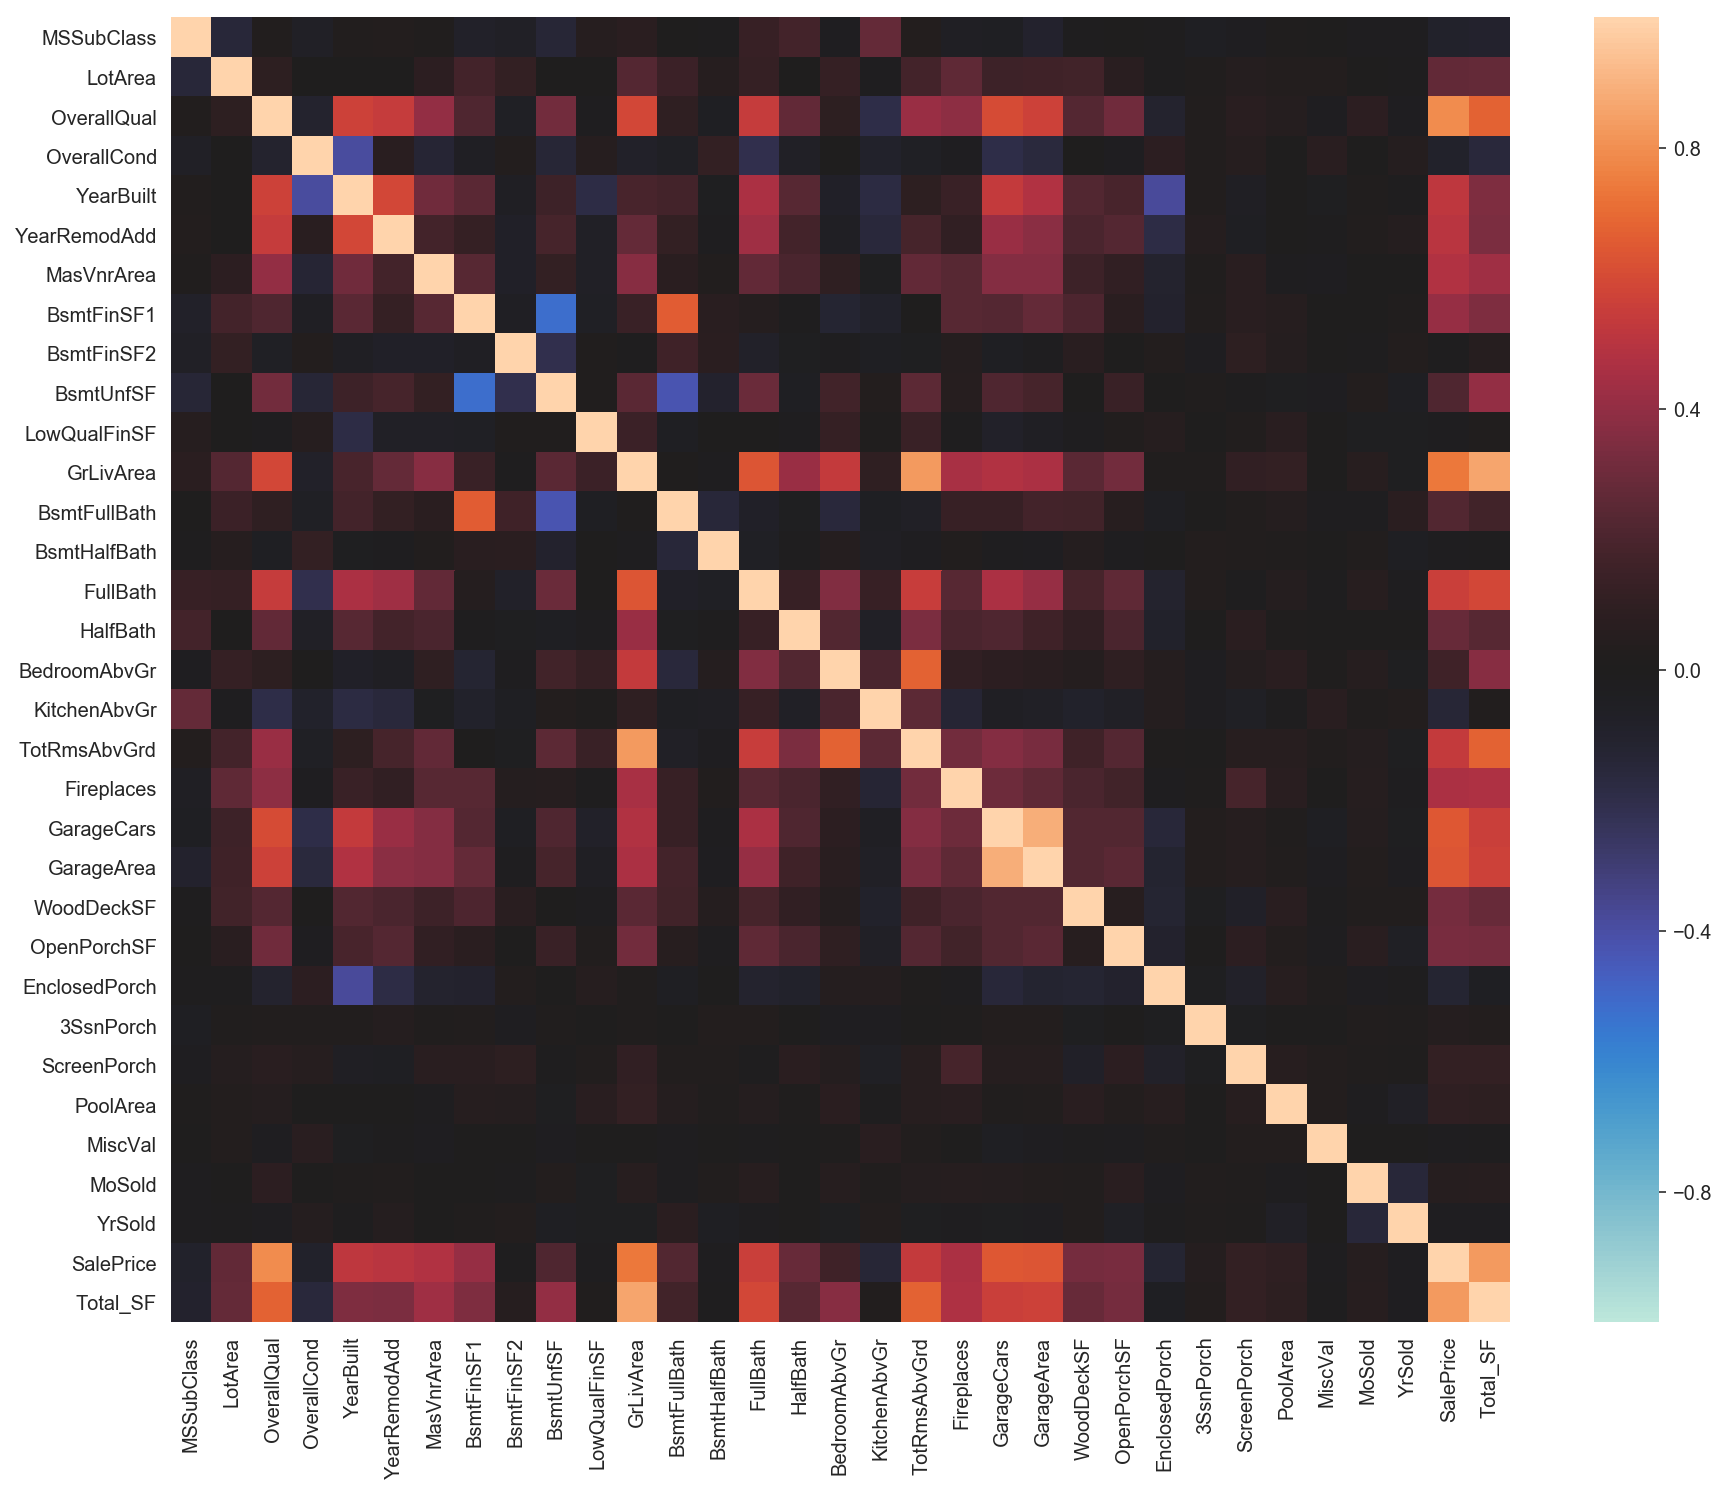

In [40]:
correlationmap=house.corr()
plt.figure(figsize=(15,12))
sns.heatmap(correlationmap, vmin=-1,vmax=1, center=0)

### Dummy variables

In [41]:
fixed_feat = house[['MSSubClass', 'MSZoning','Street','LotArea','LotShape','LandContour','LotConfig','LandSlope', 'Neighborhood', 'BldgType',
       'HouseStyle', 'YearBuilt', 'Condition1', 'Condition2', 'Foundation','RoofStyle','BsmtQual','PoolArea', 'Total_SF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath','HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageYrBlt', 'GarageArea','MiscVal', 'MoSold', 'YrSold', 'SaleType','SaleCondition', 'SalePrice']]

In [42]:
fixed_feat.select_dtypes(include=object).count()

MSZoning         1448
Street           1448
LotShape         1448
LandContour      1448
LotConfig        1448
LandSlope        1448
Neighborhood     1448
BldgType         1448
HouseStyle       1448
Condition1       1448
Condition2       1448
Foundation       1448
RoofStyle        1448
BsmtQual         1448
Functional       1448
GarageType       1448
GarageYrBlt      1448
SaleType         1448
SaleCondition    1448
dtype: int64

In [43]:
dummy_var= fixed_feat.select_dtypes(include=object)

In [44]:
dummy_df = pd.get_dummies(dummy_var, drop_first=True)

In [45]:
len(dummy_var.columns)

19

In [46]:
new_dummy= [fixed_feat, dummy_df]

In [47]:
fixed_ft = pd.concat(new_dummy, axis=1)

In [48]:
fixed_ft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1448 entries, 0 to 1459
Columns: 239 entries, MSSubClass to SaleCondition_Partial
dtypes: int64(20), object(19), uint8(200)
memory usage: 735.3+ KB


In [49]:
fixed_ft.drop(dummy_var, axis=1, inplace=True)

In [50]:
fixed_ft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1448 entries, 0 to 1459
Columns: 220 entries, MSSubClass to SaleCondition_Partial
dtypes: int64(20), uint8(200)
memory usage: 520.4 KB


##### We now have our fixed features dummified and cleaned so we can now split the data and try to fit a model

### Train-Test split

In [51]:
fixed_feat.shape

(1448, 39)

In [52]:
fixed_ft.shape

(1448, 220)

Setting our train data with houses sold before 2010

In [53]:
train_fixed_ft =  fixed_ft.loc[fixed_ft['YrSold'] < 2010]

In [54]:
train_fixed_ft.shape

(1276, 220)

Setting our target

In [55]:
y = train_fixed_ft[['SalePrice']]

In [56]:
#Logarithmic conversion of sale price
y = np.log(y)

In [57]:
y.shape

(1276, 1)

model predictors

In [58]:
X_train = train_fixed_ft.drop('SalePrice', axis=1)

In [59]:
X_train.shape

(1276, 219)

Test data with houses sold in the year 2010

In [60]:
test_fixed_ft = fixed_ft.loc[fixed_ft['YrSold'] == 2010]

In [61]:
actual_y = test_fixed_ft[['SalePrice']]

Logarithmic conversion of sale price to get normality

In [62]:
actual_y = np.log(actual_y)

In [63]:
actual_y.shape

(172, 1)

In [64]:
X_test = test_fixed_ft.drop('SalePrice', axis=1)

In [65]:
X_test.shape

(172, 219)

### Models

Standardising our predictors before fitting the model

In [66]:
# Initialize the StandardScaler object
from sklearn.preprocessing import StandardScaler

ss= StandardScaler()

Xs = ss.fit_transform(X_train)

C:\Users\anita\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\anita\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [67]:
X_stest = ss.fit_transform(X_test)

C:\Users\anita\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\anita\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [68]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, cross_val_predict
import statsmodels.api as sm 
from sklearn import metrics
from sklearn.metrics import mean_squared_error

### Linear Regression model

In [69]:
lr = LinearRegression()

lr_scores = cross_val_score(lr, Xs, y, cv=10)

print(lr_scores)
print("Mean CV R-sqaured:",np.mean(lr_scores))

[ 8.92063587e-01  8.63753051e-01  8.81908399e-01 -2.20296996e+27
 -2.35632597e+19 -2.35671754e+25 -7.12912114e+15  8.22738435e-01
 -9.58214690e+23 -6.01565962e+06]
Mean CV R-sqaured: -2.2274953744307346e+26


In [70]:
#The mean R2 is extremely negative. All the R2 scores are negative in crossvalidation.
# The linear regression is performing far worse than baseline on the test sets.
# It is probably dramatically overfitting and the redundant variables are affecting
# the coefficients in weird ways.

### RidgeCV : find the optimal Alpha

In [71]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs, y)

print(optimal_ridge.alpha_)

193.38917504552322


In [72]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs, y, cv=10)

print(ridge_scores)
print("Mean R-squared CV score:",np.mean(ridge_scores))

[0.89831535 0.86196632 0.89087202 0.83236564 0.87302202 0.86998853
 0.86605588 0.84071091 0.89685737 0.84118308]
Mean R-squared CV score: 0.8671337118831024


In [73]:
#y_hat_train = ridge_scores.predict(Xs)

In [74]:
print("Train data Ridge R-square score:",optimal_ridge.score(Xs, y))

Train data Ridge R-square score: 0.9096424869712301


In [75]:
print("Test data Ridge R-square score:",optimal_ridge.score(X_stest, actual_y))

Test data Ridge R-square score: 0.8923948331520685


### Lasso CV

In [76]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)

optimal_lasso.fit(Xs, y)

print(optimal_lasso.alpha_)

C:\Users\anita\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.004142813299824079


........................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.4s finished


In [77]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs, y, cv=10)

print(lasso_scores)
print('Mean CV R-squared score:',np.mean(lasso_scores))

[0.90023771 0.87644531 0.90080854 0.85156496 0.87684518 0.89042764
 0.86850597 0.84832443 0.90762168 0.85716687]
Mean CV R-squared score: 0.8777948285798113


In [78]:
lasso.fit(Xs, y)

Lasso(alpha=0.004142813299824079, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [79]:
print("Train data Lasso R-square score:",lasso.score(Xs, y))

Train data Lasso R-square score: 0.9003284881121953


In [80]:
print("Test data Lasso R-square score:",lasso.score(X_stest, actual_y))

Test data Lasso R-square score: 0.8978319592487223


In [81]:
# Lasso performs slightly better than ridge and way better than cross_val_lr model! 

In [82]:
lasso_coefs = pd.DataFrame({'variable': X_train.columns,
                            'coefs': lasso.coef_ ,
                            'abs_coefs': np.abs(lasso.coef_ )})

In [83]:
lasso_coefs.head()

,variable,coefs,abs_coefs
0,MSSubClass,-0.000000,0.000000
1,LotArea,0.017843,0.017843
2,YearBuilt,0.062446,0.062446
3,PoolArea,0.000000,0.000000
4,Total_SF,0.111908,0.111908


In [84]:
lasso_coefs.sort_values(by ='coefs', inplace=True, ascending=False)

### Top ten estimates of house sale price

In [85]:
lasso_coefs.head(10)

,variable,coefs,abs_coefs
4,Total_SF,0.111908,0.111908
6,GrLivArea,0.106875,0.106875
2,YearBuilt,0.062446,0.062446
15,GarageArea,0.038129,0.038129
7,BsmtFullBath,0.034071,0.034071
103,Functional_Typ,0.028356,0.028356
211,SaleType_New,0.026449,0.026449
14,Fireplaces,0.026084,0.026084
40,Neighborhood_Crawfor,0.022793,0.022793
50,Neighborhood_NridgHt,0.022129,0.022129


### Top influential coefficients for my model are:
##### the feature engineered predictor(total square feet), SF followed by yearbuilt, how many car spaces ar available, number of bathrooms in the basement, foundation of the house, new houses , number of fireplaces followed by the area the house is in.

### Predict the sale price from the lasso model

In [86]:
# y pred values for test data for houses sold in 2010
y_pred = lasso.predict(X_stest)

In [87]:
#Y_pred values for X train data set for houses before 2010
y_pred1 = lasso.predict(Xs)

In [88]:
#Actual given sale price converted to a dataframe
sale_price = pd.DataFrame(actual_y)

In [89]:
#Predicted test data sale price converted to data frame so its easier to interpret and compare the difference in the prices
pred_sale_price = pd.DataFrame(y_pred)

In [90]:
pred_sale_price.rename(columns={0:'Predicted_sale_price'}, inplace=True)

### Comparing the predicted prices from lasso model to the actual prices

In [91]:
pred_sale_price.describe()

,Predicted_sale_price
count,172.000000
mean,12.032320
std,0.371265
min,11.163194
25%,11.785498
50%,11.968767
75%,12.313157
max,13.236074


In [92]:
sale_price.describe()

,SalePrice
count,172.000000
mean,12.015007
std,0.394833
min,10.915088
25%,11.767471
50%,11.960449
75%,12.271977
max,13.323927


C:\Users\anita\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


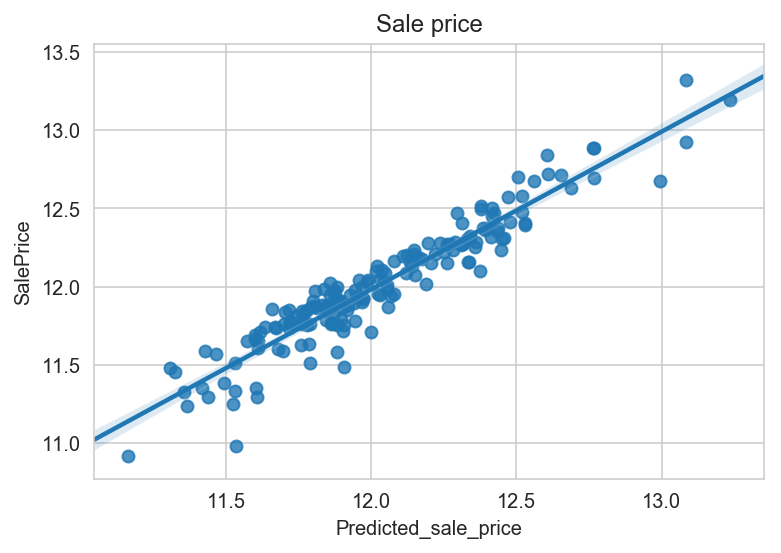

In [93]:
sns.regplot(pred_sale_price.Predicted_sale_price, sale_price.SalePrice);
plt.title('Sale price');

### Calculating residuals

In [94]:
y_pred = pd.DataFrame(y_pred)
y_pred.rename(columns={0:'test_pred_price'}, inplace=True)

In [95]:
y_pred1 = pd.DataFrame(y_pred1)
y_pred1.rename(columns={0:'train_pred_price'},inplace=True)

In [96]:
y.shape

(1276, 1)

In [97]:
y_pred1.shape

(1276, 1)

In [98]:
y_train= y.SalePrice.values - y_pred1.train_pred_price.values

In [99]:
y_test = actual_y.SalePrice.values - y_pred.test_pred_price.values

In [100]:
#Setting y_train for next question
y_train = pd.DataFrame(y_train)

In [101]:
#y_test calculated from the residuals 
y_test = pd.DataFrame(y_test)

In [102]:
y_train.rename(columns={0:'y_train'}, inplace=True)
y_train.shape

(1276, 1)

In [103]:
y_test.rename(columns={0:'y_test'}, inplace=True)
y_test.shape

(172, 1)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [104]:
reno_ft = house[['Utilities','OverallQual','OverallCond','BsmtFinType1','BsmtFinSF1','BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
                 'KitchenQual','Heating','HeatingQC', 'CentralAir', 'Electrical','GarageQual','GarageCond', 'PavedDrive',
                 'WoodDeckSF', 'OpenPorchSF','EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea','YrSold']]

In [105]:
reno_ft.GarageCond.replace(np.nan, 'TA', inplace=True)

C:\Users\anita\Anaconda3\lib\site-packages\pandas\core\generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [106]:
reno_ft.columns

Index(['Utilities', 'OverallQual', 'OverallCond', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'KitchenQual', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'YrSold'],
      dtype='object')

In [107]:
#Checking for null values if any
reno_ft.isnull().sum()

Utilities        0
OverallQual      0
OverallCond      0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
KitchenQual      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
YrSold           0
dtype: int64

In [108]:
reno_ft.shape

(1448, 23)

In [109]:
reno_ft.select_dtypes(include=object).count()

Utilities       1448
BsmtFinType1    1448
BsmtFinType2    1448
KitchenQual     1448
Heating         1448
HeatingQC       1448
CentralAir      1448
Electrical      1448
GarageQual      1448
GarageCond      1448
PavedDrive      1448
dtype: int64

In [110]:
reno_ft.columns

Index(['Utilities', 'OverallQual', 'OverallCond', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'KitchenQual', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'YrSold'],
      dtype='object')

In [111]:
#to_dummified = reno_ft[['Utilities','BsmtFinType1','BsmtFinType2','KitchenQual','Heating','HeatingQC','CentralAir','Electrical','GarageQual','GarageCond','PavedDrive']]

### Dummifying the changeable features

In [112]:
X1 = pd.get_dummies(reno_ft,columns=['Utilities','BsmtFinType1','BsmtFinType2','KitchenQual','Heating','HeatingQC','CentralAir','Electrical','GarageQual','GarageCond','PavedDrive'], drop_first=True)

In [113]:
#Standardising the predictors
XS1 = ss.fit_transform(X1)

C:\Users\anita\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\anita\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### train-test split

In [114]:
reno_X_train = X1.loc[X1['YrSold'] < 2010]

In [115]:
reno_X_test = X1.loc[X1['YrSold'] == 2010]

In [116]:
reno_X_train.shape

(1276, 50)

In [117]:
reno_X_test.shape

(172, 50)

### Linear regression model with residuals as the new target

In [118]:
linreg = LinearRegression()

lr = linreg.fit(reno_X_train, y_train)

In [119]:
y_hat_1 = lr.predict(reno_X_train)

In [120]:
y_hat_2 = lr.predict(reno_X_test)

In [121]:
metrics.r2_score(y_train, y_hat_1)

0.3131498536798175

In [122]:
metrics.r2_score(y_test, y_hat_2)

0.19700689178276443

C:\Users\anita\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


ValueError: Input passed into argument "'y1'"is not 1-dimensional.

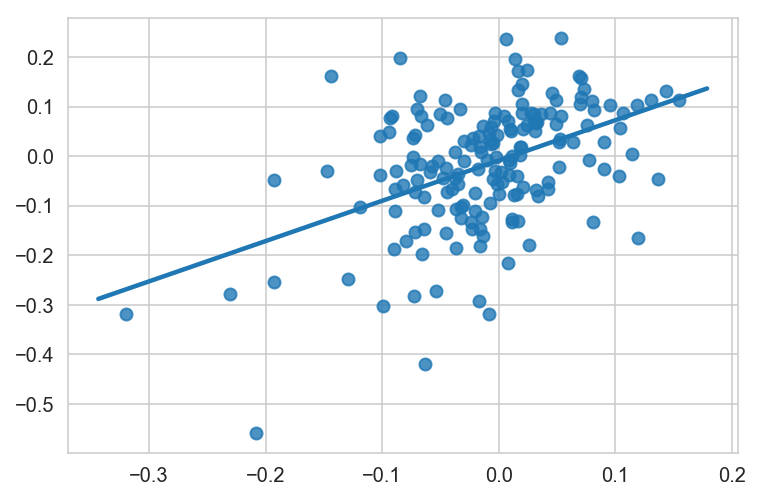

In [123]:
sns.regplot(y_hat_2, y_test);

ValueError: Input passed into argument "'y1'"is not 1-dimensional.

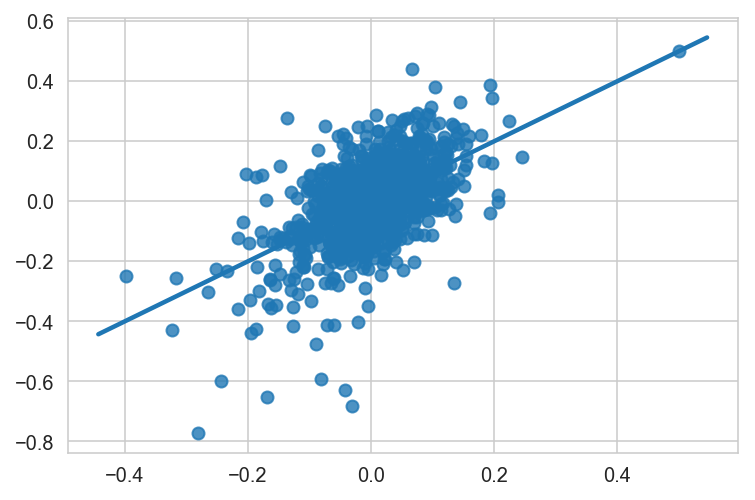

In [124]:
sns.regplot(y_hat_1, y_train);

In [125]:
#linear regression by itself is overfitting and has high variance so the train score is greater than test
# we need to increase bias 

### Cross-validation

In [126]:
lr2_scores = cross_val_score(linreg, reno_X_train, y_train, cv=10)

print(lr2_scores)
print(np.mean(lr2_scores))

[0.01587084 0.30045714 0.21722641 0.26269731 0.18593656 0.02602146
 0.16831634 0.41228834 0.22279039 0.15436199]
0.19659667682035514


In [127]:
pred = cross_val_predict(linreg, reno_X_train, y_train, cv=10)

In [128]:
metrics.r2_score(y_train, pred)

0.21717281669267585

In [129]:
linreg_test_scores = cross_val_score(linreg, reno_X_test, y_test, cv=10)

print(linreg_test_scores)
print(np.mean(linreg_test_scores))

[ 0.05607048 -0.31740876 -0.22418493 -0.61431982 -0.38419888 -0.22381461
  0.10475411  0.27830221 -0.14396678 -0.4800951 ]
-0.1948862057846224


In [130]:
pred1 = cross_val_predict(linreg, reno_X_test, y_test, cv=10)

In [131]:
metrics.r2_score(y_test, pred1)

-0.1967320303732294

In [132]:
#Cross validation is worse as the test score is negative, we need to regularise the model

### Ridge model

In [133]:
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(reno_X_train, y_train)

print(optimal_ridge.alpha_)

38.27494478516313


In [134]:
y_hat_tr = optimal_ridge.predict(reno_X_train)

In [135]:
y_hat_te = optimal_ridge.predict(reno_X_test)

In [136]:
optimal_ridge.score(reno_X_train, y_train)

0.2905786345331971

In [137]:
optimal_ridge.score(reno_X_test, y_test)

0.19716067716199626

In [138]:
print("R2 score train data score:", metrics.r2_score(y_train, y_hat_tr))

R2 score train data score: 0.2905786345331971


In [139]:
print("RMSE train score:", metrics.mean_squared_error(y_train, y_hat_tr))

RMSE train score: 0.010845075507577658


In [140]:
print("RMSE test score:", metrics.mean_squared_error(y_test, y_hat_te))

RMSE test score: 0.012472077410009398


In [141]:
print("R2 score test data score:", metrics.r2_score(y_test, y_hat_te))

R2 score test data score: 0.19716067716199626


In [142]:
### Ridge score are slightly better than linear as the test and train scores are slightly closer 

In [143]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)

optimal_lasso.fit(reno_X_train, y_train)

print(optimal_lasso.alpha_)

C:\Users\anita\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.00670853371868041


.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.5s finished


In [144]:
lasso1 = Lasso(alpha=optimal_lasso.alpha_)

In [145]:
lasso1.fit(reno_X_train, y_train)

Lasso(alpha=0.00670853371868041, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [146]:
print("Lasso R2 train score:", lasso1.score(reno_X_train, y_train))

Lasso R2 train score: 0.2551328447403175


In [147]:
print("Lasso R2 test score:", lasso1.score(reno_X_test, y_test))

Lasso R2 test score: 0.1647872854749598


In [148]:
lasso1_coefs = pd.DataFrame({'variable': reno_X_train.columns,
                            'coefs': lasso1.coef_ })

In [149]:
lasso1_coefs.sort_values(by ='coefs', inplace=True, ascending=False)

In [150]:
lasso1_coefs.head(10)

,variable,coefs
1,OverallCond,0.037324
0,OverallQual,0.024328
9,ScreenPorch,0.000165
8,3SsnPorch,0.000098
6,OpenPorchSF,0.000078
5,WoodDeckSF,0.000057
7,EnclosedPorch,0.000056
38,Electrical_Mix,0.000000
30,Heating_Wall,0.000000
31,HeatingQC_Fa,-0.000000


In [151]:
#I would advise the company to use model from question 1 as predicting with non changeable features leads to greater accuracy

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [152]:
# A: